# 슈퍼바이저 멀티 에이전트 
- 구글 제미나이 사용
https://medium.com/@dharamai2024/build-a-multi-agent-system-with-langgraph-5b938e0104b5

Gemini API키는 다음 사이트에서 [Google AI 스튜디오](https://aistudio.google.com/app/apikey?hl=ko) 등록합니다.

<img src="https://miro.medium.com/v2/resize:fit:786/format:webp/1*MLHRiyXv7py7vT--wupJeA.png" />

## 환경 설정

In [1]:
!python --version

Python 3.13.4


In [2]:
%pip install -qU python-dotenv langchain pypdf langchain-community langgraph langchain-tavily langchain-google-genai langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [3]:
# 환경 변수 확인
from dotenv import load_dotenv
import os
load_dotenv(override=True)

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("GOOGLE_API_KEY")
_set_env("TAVILY_API_KEY")

print(os.environ.get("OPENAI_API_KEY")[:10])
print(os.environ.get("GOOGLE_API_KEY")[:10])
print(os.environ.get("TAVILY_API_KEY")[:10])

sk-proj-8x
AIzaSyB_bx
tvly-dev-G


In [4]:

import os
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from typing import Annotated, TypedDict, Literal, Sequence
from pydantic import BaseModel, Field
from langgraph.graph import START, StateGraph, MessagesState, add_messages, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from langchain_core.messages import BaseMessage, SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.schema import HumanMessage
from langchain.tools import Tool
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.types import Command, interrupt
from langchain_core.output_parsers import StrOutputParser


In [5]:
# from langchain_google_genai import GoogleGenerativeAIEmbeddings
# from langchain_google_genai import ChatGoogleGenerativeAI

# embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
# llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", 
#                              temperature=0)

In [6]:
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",  # 가격이 저렴
)
llm = ChatOpenAI(model_name="gpt-4o-mini")

## 도구 만들기

LangGraph를 사용하는 이 다중 에이전트 시스템 은 7명의 전문 에이전트 로 구성되며 , 각 에이전트는 고유한 책임과 툴셋을 가지고 있습니다. 핵심적으로, 슈퍼바이저 에이전트는 쿼리 유형에 따라 가장 적합한 에이전트에게 작업을 동적으로 라우팅하여 전체 워크플로를 조율합니다.

저희 에이전트 팀에 대한 개요는 다음과 같습니다.

- **Supervisor Agent**는 중앙 조정자 역할을 합니다. 사용자 입력을 받아 적절한 전문 에이전트에게 작업을 위임합니다.
- **Enhancer Agent**는 다른 에이전트에게 전달되기 전에 사용자의 쿼리를 세부화하거나 향상시킵니다(예: 명확성이나 맥락 추가).
- **Validator Agent**는 사용자의 질문과 최종 응답을 모두 검증하여 정확성, 완전성, 안전성을 보장합니다.
- **Researcher Agent**는 검색 엔진 도구(예: Tavily)를 사용하여 실시간 웹 조사를 수행하여 최신 정보를 검색합니다.
- **PDF_RAG Agent**는 PDF 검색기를 사용하여 PDF 컬렉션에서 관련 콘텐츠를 검색하고 RAG(검색 증강 생성) 기술을 적용합니다.
- **Movie_RAG Agent**는 CSV 기반 검색기를 사용하여 영화 데이터 세트와 관련된 질문에 답합니다.
- **Math Expert Agent**는 Wolfram이나 LangChain의 내장된 수학 기능과 같은 계산 도구를 사용하여 수학 문제를 해결합니다.

### Research Agent Tool:

In [7]:
from langchain_tavily import TavilySearch

web_search_tool = TavilySearch(max_results=2)

### PDF Agnet Tool

In [8]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

def load_pdf_documents(file_path):
  documents = []
  for file in os.listdir(file_path):
    if file.endswith(".pdf"):
        print("File:", file)
        loader = PyPDFLoader(os.path.join(file_path, file))
        documents.extend(loader.load())
  return documents

# upload and create documents
documents = load_pdf_documents("./docs")
print(f"{len(documents)} documents loaded")

File: SPRi AI Brief_6월호_산업동향_F.pdf
28 documents loaded


In [9]:
text_splitter = RecursiveCharacterTextSplitter(
     chunk_size=300,
     chunk_overlap=20,
     length_function=len,
     is_separator_regex=False,
 )

splits = text_splitter.split_documents(documents)
print(f"Split the documents into {len(splits)} chunks.")

Split the documents into 159 chunks.


In [10]:
# !pip install -qU langchain-chroma

In [11]:
 # from langchain_chroma import Chroma

 # collection_name = "my_collection"
 # vectorstore = Chroma.from_documents(
 #     collection_name=collection_name,
 #     documents=splits,
 #     embedding=embeddings
 # )


In [12]:
# %pip install -qU faiss-cpu

In [13]:
from langchain_community.vectorstores import FAISS

pdf_vectors = FAISS.from_documents(documents=splits, 
                                   embedding=embeddings)

In [14]:
class PDFToolSchema(BaseModel):
  question: str = Field(description="문서에 대한 질문")

# PDF RETRIEVER TOOL
@tool(args_schema=PDFToolSchema)
def pdf_documents_tool(question):
  """문서와 관련된 사용자 질문에 답변하기 위해 의미적으로 유사한 문서를 검색하는 도구"""
  print("INSIDE pdf_documents_tool")
  retriever = pdf_vectors.as_retriever(search_type='similarity', search_kwargs={"k": 3})
  docs = retriever.invoke(question)
  return "/n/n".join(doc.page_content for doc in docs)

### Movie Agent Tool

In [15]:
from langchain_community.document_loaders import CSVLoader
from langchain_chroma import Chroma


# Load movie data from csv file
load_movie_data = CSVLoader("./data/top_100_movies.csv")
data = load_movie_data.load()

# Split the documents into smaller chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(data)

movie_vectors = FAISS.from_documents(documents=docs, 
                                   embedding=embeddings)

In [16]:
class MovieToolSchema(BaseModel):
  question: str = Field(description="Question about the Movies csv document")

# MOVIE RETRIEVER TOOL
@tool(args_schema=MovieToolSchema)
def movie_documents_tool(question):
  """Tool to Retrieve Semantically Similar documents to answer User Questions related movies, share info from csv documents"""
  print("INSIDE movie_documents_tool")
  retriever = movie_vectors.as_retriever(search_type='similarity' , search_kwargs={"k": 5})
  docs = retriever.invoke(question)
  return "/n/n".join(doc.page_content for doc in docs)

### Math Agent Tools:

In [17]:
@tool
def get_sum(a: float, b: float) -> float:
    """Returns the sum of two numbers."""
    return a + b

@tool
def get_subtraction(a: float, b: float) -> float:
    """Returns the subtraction of two numbers."""
    return a - b

@tool
def get_multiplication(a: float, b: float) -> float:
    """Returns the multiplication of two numbers."""
    return a * b

@tool
def get_division(a: float, b: float) -> float:
    """Returns the division of two numbers."""
    if b == 0:
        return float("inf")  # or raise an error
    return a / b

@tool
def get_modulus(a: float, b: float) -> float:
    """Returns the modulus of two numbers."""
    if b == 0:
        return float("nan")  # or raise an error
    return a % b

@tool
def get_power(a: float, b: float) -> float:
    """Returns the result of raising a to the power of b."""
    return a ** b

## 에이전트 구성

이제 모든 도구가 준비되었으므로, 에이전트 구축을 시작할 수 있습니다.  
`Command` 클래스를 사용하여 **상태(State)** 를 업데이트하고, 서로 다른 노드 또는 에이전트 간의 **라우팅을 관리**할 것입니다.

### Enhancer 에이전트

사용자의 질의를 다른 에이전트에게 전달하기 전에 내용을 명확히 하거나 문맥을 추가하여 질의를 정제하거나 향상시키는 역할을 합니다.

In [18]:
def enhancer_node(state: MessagesState) -> Command[Literal["supervisor"]]:

    """
    사용자 질의를 개선하고 명확하게 만드는 향상(Enhancer) 에이전트 노드입니다.
    원래의 사용자 입력을 받아 보다 정확하고 실행 가능한 요청으로 변환한 후,
    이를 슈퍼바이저에게 전달합니다.
    """

    system_prompt = (
        "당신은 사용자의 모호한 요청을 명확한 지시로 변환하는 데 전문성을 가진 질의 개선 전문가입니다. 당신의 책임은 다음과 같습니다:\n\n"
        "1. 원래의 질의를 분석하여 핵심 의도와 요구 사항을 식별합니다.\n"
        "2. 추가적인 사용자 입력을 요청하지 않고 모든 모호함을 해결합니다.\n"
        "3. 충분히 구체화되지 않은 질의의 부분을 합리적인 가정을 통해 확장합니다.\n"
        "4. 질의를 명확하고 실행 가능한 형태로 재구성합니다.\n"
        "5. 모든 기술 용어가 문맥상 적절하게 정의되어 있는지 확인합니다.\n\n"
        "중요: 사용자에게 다시 질문하지 마십시오. 대신, 정보에 기반한 가정을 통해 가능한 가장 포괄적인 형태의 요청을 작성하십시오."
    )

    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]

    enhanced_query = llm.invoke(messages)

    print(f"--- Workflow Transition: Prompt Enhancer → Supervisor ---")

    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=enhanced_query.content,
                    name="enhancer"
                )
            ]
        },
        goto="supervisor",
    )

### 검증(Validator) 에이전트

In [19]:
# System prompt providing clear instructions to the validator agent
system_prompt = '''
    당신의 임무는 합리적인 품질을 보장하는 것입니다.  
    구체적으로 다음을 수행해야 합니다:
    
    - 사용자의 질문(워크플로의 첫 번째 메시지)을 검토합니다.  
    - 응답(워크플로의 마지막 메시지)을 검토합니다.  
    - 응답이 질문의 핵심 의도를 완전히 충족하지는 않더라도 어느 정도 충족한다면, 'FINISH'로 워크플로를 종료하도록 지시합니다.  
    - 응답이 완전히 엉뚱하거나, 해롭거나, 질문을 근본적으로 오해한 경우에만 supervisor로 다시 라우팅합니다.
    
    - "충분히 괜찮은" 응답은 수용합니다. 완벽할 필요는 없습니다.  
    - 워크플로의 완료를 완벽한 응답보다 우선시합니다.  
    - 경계선에 있는 응답에는 의심의 여지를 주고 수용하는 쪽을 택합니다.
    
    라우팅 지침:  
    1. 'supervisor' 에이전트: 응답이 완전히 잘못되었거나 엉뚱한 경우에만 해당  
    2. 그 외 모든 경우에는 'FINISH'로 응답하여 워크플로를 종료합니다.
'''

class Validator(BaseModel):
    next: Literal["supervisor", "FINISH"] = Field(
        description="파이프라인에서 다음 작업자를 지정합니다. 계속 진행하려면 'supervisor', 종료하려면 'FINISH'를 사용합니다."
    )
    reason: str = Field(
        description="결정을 내린 이유."
    )

def validator_node(state: MessagesState) -> Command[Literal["supervisor", "__end__"]]:

    user_question = state["messages"][0].content
    agent_answer = state["messages"][-1].content

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_question},
        {"role": "assistant", "content": agent_answer},
    ]

    response = llm.with_structured_output(Validator).invoke(messages)

    goto = response.next
    reason = response.reason

    if goto == "FINISH" or goto == END:
        goto = END
        print(" --- Transitioning to END ---")
    else:
        print(f"--- Workflow Transition: Validator → Supervisor ---")

    
    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="validator")
            ]
        },
        goto=goto,
    )

### 개별 에이전트 구현:


이제 각 에이전트를 정의하기 위해, 개별 LangGraph 그래프를 생성하는 사용자 정의 함수를 사용해 보겠습니다.  
이러한 모듈형 방식은 각 에이전트가 고유한 워크플로우를 가지도록 하여 독립적으로 동작할 수 있게 하며, 요청을 처리하고 도구를 활용하는 구조는 일관되게 유지할 수 있습니다.

In [20]:
# Custom Agent State
class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Create Custom Agent with llm and tools
def create_agent(llm, tools):
    llm_with_tools = llm.bind_tools(tools)

    def chatbot(state: AgentState):
        return {"messages": [llm_with_tools.invoke(state["messages"])]}

    graph_builder = StateGraph(AgentState)
    graph_builder.add_node("agent", chatbot)

    tool_node = ToolNode(tools=tools)
    graph_builder.add_node("tools", tool_node)

    graph_builder.add_conditional_edges(
        "agent",
        tools_condition,
    )
    graph_builder.add_edge("tools", "agent")
    graph_builder.set_entry_point("agent")
    return graph_builder.compile()

### Agent Researcher and Graph Node:

검색 엔진 도구(예: Tavily)를 사용하여 실시간 웹 조사를 수행하고 최신 정보를 검색합니다.

In [21]:
researcher_agent = create_agent(llm, [web_search_tool])

def researcher_node(state: MessagesState) -> Command[Literal["validator"]]:
    result = researcher_agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content,
                    name="researcher"
                )
            ]
        },
        goto="validator",
    )

### Agent Pdf RAG and Graph Node:

PDF 리트리버를 사용하여 여러 PDF 문서에서 관련 내용을 검색하고, RAG(검색 증강 생성) 기법을 적용합니다.

In [22]:
pdf_agent = create_agent(llm, [pdf_documents_tool])

def pdf_node(state: MessagesState) -> Command[Literal["validator"]]:
    result = pdf_agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content,
                    name="pdf_rag"
                )
            ]
        },
        goto="validator",
    )

### Agent Movie RAG and Graph Node:

CSV 기반 리트리버를 사용하여 영화 데이터셋과 관련된 질문에 답변합니다.

In [23]:
movie_agent = create_agent(llm, [movie_documents_tool])

def movie_node(state: MessagesState) -> Command[Literal["validator"]]:
    result = movie_agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content,
                    name="movie_rag"
                )
            ]
        },
        goto="validator",
    )

### Agent Math Expert and Graph Node:

Wolfram이나 LangChain의 내장 수학 기능과 같은 계산 도구를 사용하여 수학 문제를 해결합니다.

In [24]:
math_expert_agent = create_agent(llm, [get_sum, get_subtraction, get_multiplication, get_division, get_modulus, get_power])

def math_expert_Node(state: MessagesState) -> Command[Literal["validator"]]:
    result = math_expert_agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content,
                    name="math_expert"
                )
            ]
        },
        goto="validator",
    )

### Implementing the Supervisor Agent:

Supervisor 에이전트는 전문화된 에이전트들 간의 대화 흐름을 조율하는 역할을 담당합니다. 현재 작업을 어떤 에이전트가 처리할지 결정하고, 에이전트 간의 전환을 관리합니다. 작업이 완료되면 Supervisor는 응답을 최종 확정하거나 추가 처리를 다른 에이전트에 위임합니다. 이제 이러한 로직을 어떻게 구현하는지 살펴보겠습니다.

In [25]:
class Supervisor(BaseModel):
    next: Literal["enhancer", "researcher", "pdf_rag", "movie_rag", "math_expert"] = Field(
        description="워크플로우 순서에서 다음으로 활성화할 전문가를 결정합니다: "
                    "'enhancer'는 사용자 입력에 명확화, 확장 또는 정제가 필요한 경우, "
                    "'researcher'는 추가적인 사실, 맥락 또는 데이터 수집이 필요한 경우에 사용됩니다. "
    )
    reason: str = Field(
        description="특정 전문가를 선택한 결정에 대한 자세한 정당화로, 선택한 이유와 이 선택이 과업을 완수하는 데 어떻게 기여하는지를 설명합니다."
    )

def supervisor_node(state: MessagesState) -> Command[Literal["enhancer", "researcher", "pdf_rag", "movie_rag", "math_expert"]]:

    system_prompt = ('''

        당신은 Prompt Enhancer, Researcher, PDF Documents RAG, Movie Documents RAG, Math Expert, 이렇게  5개의 전문 에이전트로 구성된 팀을 관리하는 워크플로우 감독자입니다. 당신의 역할은 작업의 현재 상태와 요구 사항에 따라 가장 적절한 다음 에이전트를 선택하여 워크플로우를 조율하는 것입니다. 각 결정에 대해 명확하고 간결한 근거를 제공하여 의사결정 과정을 투명하게 유지하십시오.
        
        **팀 구성원**:
        1. **Prompt Enhancer**: 항상 이 에이전트를 우선적으로 고려하세요. 이 에이전트는 모호한 요청을 명확히 하고, 정의가 불충분한 질의를 개선하며, 보다 깊은 처리를 시작하기 전에 작업이 잘 구조화되었는지 확인합니다.
        2. **Researcher**: 정보 수집, 사실 확인, 사용자 요청을 처리하는 데 필요한 관련 데이터 수집을 전문으로 합니다. 금융 관련 질문은 처리하지 않습니다.
        3. **PDF Documents RAG**: 벡터 데이터베이스에서 관련 문서를 수집하고 검색하는 데 특화되어 있습니다.
        4. **Movie Documents RAG**: 영화와 관련된 벡터 데이터베이스에서 관련 문서를 수집하고 검색하는 데 특화되어 있습니다.
        5. **Math Expert**: 수학 연산을 전문으로 처리합니다. 수학 관련 질문이 있을 경우 반드시 Math Expert 도구만 호출하십시오.
        
        **당신의 책임**:
        1. 각 사용자 요청과 에이전트 응답을 완전성, 정확성, 관련성 측면에서 분석합니다.
        2. 각 결정 시점에서 작업을 가장 적절한 에이전트에게 라우팅합니다.
        3. 중복되는 에이전트 할당을 피하여 워크플로우의 효율성을 유지합니다.
        4. 사용자의 요청이 완전하고 만족스럽게 해결될 때까지 프로세스를 계속합니다.
        
        당신의 목표는 각 에이전트의 강점을 효과적으로 활용하면서 불필요한 단계를 최소화하고, 궁극적으로 사용자 요청에 대해 완전하고 정확한 솔루션을 제공하는 효율적인 워크플로우를 만드는 것입니다.
        
    ''')

    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]

    response = llm.with_structured_output(Supervisor).invoke(messages)

    goto = response.next
    reason = response.reason

    print(f"--- Workflow Transition: Supervisor → {goto.upper()} ---")

    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="supervisor")
            ]
        },
        goto=goto,
    )

## Putting It All Together
### 그래프 만들기

마지막으로, 모든 에이전트를 연결하는 메인 그래프를 생성해봅시다:

In [26]:
builder = StateGraph(MessagesState)

builder.add_node("supervisor", supervisor_node)
builder.add_node("enhancer", enhancer_node)
builder.add_node("researcher", researcher_node)
builder.add_node("pdf_rag", pdf_node)
builder.add_node("movie_rag", movie_node)
builder.add_node("math_expert", math_expert_Node)
builder.add_node("validator", validator_node)

builder.add_edge(START, "supervisor")
graph = builder.compile()

### Visualizing the LangGraph

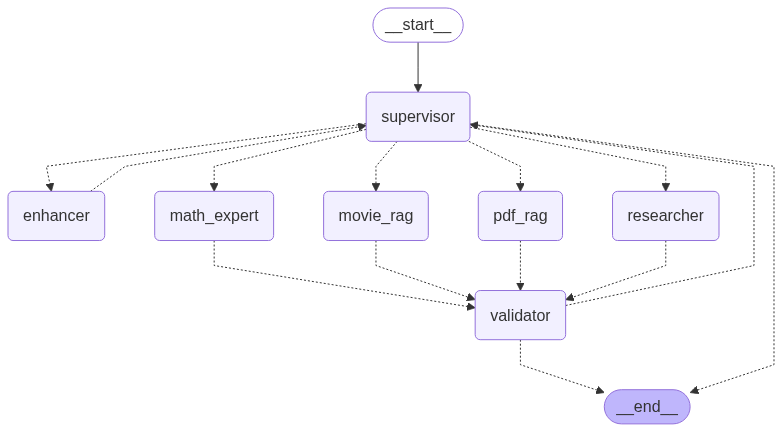

In [27]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # You can put your exception handling code here
    pass

## 실행

In [29]:
import pprint

inputs = {
    "messages": [
        ("user", "제주의 날씨는? "),
    ]
}

for event in graph.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        last_message = value.get("messages", [])[-1] if "messages" in value else None
        if last_message:
            pprint.pprint(f"******Output from node****** '{key}':")
            pprint.pprint(last_message, indent=2, width=80, depth=None)
            print()

--- Workflow Transition: Supervisor → RESEARCHER ---
"******Output from node****** 'supervisor':"
HumanMessage(content='제주의 날씨에 대한 정보는 현재 데이터 수집을 필요로 하므로 Researcher 에이전트를 호출하여 관련 정보를 검색할 수 있도록 하겠습니다.', additional_kwargs={}, response_metadata={}, name='supervisor', id='6f5e3891-7148-43f3-9626-07f0c01b2dc5')

"******Output from node****** 'researcher':"
HumanMessage(content='현재 제주의 날씨에 대한 정보를 아래의 링크에서 확인할 수 있습니다.\n\n1. [AccuWeather - 제주시, 제주도](https://www.accuweather.com/ko/kr/jeju/224209/weather-forecast/224209)\n   - 제주시에서는 흐리고 습하며 일부 지역에 뇌우가 내릴 가능성이 있습니다. 다소 높은 기온과 습도가 예상됩니다.\n\n2. [기상청 - 제주특별자치도 중기예보](https://www.weather.go.kr/w/weather/forecast/mid-term.do?stnId1=184)\n   - 13일(일)에서 14일(월) 사이에 비가 내릴 예정이며, 아침 기온은 24~26도, 낮 기온은 30~32도로 예상됩니다.\n\n이 링크들을 통해 자세한 날씨 예보를 확인하세요!', additional_kwargs={}, response_metadata={}, name='researcher', id='c7e7f170-4a9e-4e1a-91a9-ec7c233094c2')



Task validator with path ('__pregel_pull', 'validator') wrote to unknown channel branch:to:__end__, ignoring it.


 --- Transitioning to END ---
"******Output from node****** 'validator':"
HumanMessage(content='응답에서 제주 날씨에 대한 정보와 관련된 링크를 제공하여 질문의 의도를 부분적으로 충족했습니다.', additional_kwargs={}, response_metadata={}, name='validator', id='d76a9907-9b38-40d1-a358-5dd03e12364e')

